## 1주차 — 데이터/EDA/스키마
- 데이터 다운로드·정합성 체크, 시계열 분할 기준 확정
- Train set 구성 기획

## Checklist
- `data/processed/`에 **interactions/items 파케이** 생성 & 행수 요약 기록
    - ```python loader.py --behaviors data/MINDsmall_train/behaviors.tsv --news data/MINDsmall_train/news.tsv ```
- **세션화**가 적용된 `interactions`(session_id 포함) 샘플 검증
    * unique users : 50000 명 (small)
    * unique items : 51282 개
    * unique sessions : 146403 개
- **품질 체크(널/중복/시간/카디널리티)** 결과 표/캡처 첨부
    * interactions
        * Null : 0
    * items
        * Null : abstract 컬럼 2,666건 (5%)
- **시계열 분할·네거티브 샘플링 설계서** 확정(다음 주 입력으로 사용)
    * impression_id 를 기준으로 시간 순서상 가장 마지막을 test set, 그 이전을 validation set, 나머지 과거 시점의 set를 train set 으로 분할
- **MLflow UI 구동** 및 실험 로깅 테스트 1회 성공(더미 메트릭 OK)
- **산출물**: `01_eda.ipynb`, `schema.json`, `src/data/loader.py`, `utils/logging_utils.py` 
- 이슈·리스크 로그(결측/편향)

### EDA [Small version]
* 유저/아이템 분포
    * unique users : 50000 명 (small)
    * unique items : 51282 개
* 세션 수
    * unique sessions : 146403 개
    * session count stats per user : 평균 2.92개 / 최대 55개
* 카테고리 커버리지
    * 카테고리 가짓수
        * 대 카테고리 17가지 / 하위 카테고리 264가지
    * 카테고리 별 item 분포
        * 50% 이상이 news 와 sports 카테고리에 속함
    * user 단위 카테고리 view & click 분포
        * 평균 10가지의 카테고리를 봄
* 시간대 패턴
    * 시간대 별 클릭된 뉴스의 카테고리 분포
        * 대부분 출근 시간대인 오전 7~8시 , 점심시간 이전인 10~12시에 편중됨
    * 카테고리 별 시간대 분포
        * 아침+점심 시간대에 몰려있는 경우, 아침 시간대에만 몰려있는 경우, 점심시간대에만 몰려있는 경우, 저녁 시간대에 몰려있는 경우가 있고 카테고리별로 상이함
* CTR (in user session)
    * CTR 분포 및 통계
        * User level 평균 8.5% 정도의 CTR, Session level 평균 10.6% 정도의 CTR
    * Position 별 CTR 차이
        * 노출은 1~10번 순으로 많이 되지만 CTR 에는 큰 차이가 없음
    * 카테고리 별 / 하위카테고리 별 CTR 차이
        * 카테고리 별 CTR 은 music, tv, weather 순으로 높음
    * 시간대별 CTR 차이
        * 오전 8~9시, 오후 9시~10시에 CTR 이 높아지는 경향

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [3]:
items_df = pd.read_pickle('../data/processed/items.pkl')
items_df.head()

,item_id,category,subcategory,title,abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


In [4]:
# 51282 개의 item
items_df.shape[0], items_df['item_id'].nunique(), 

(51282, 51282)

In [5]:
items_df.isnull().sum()

item_id           0
category          0
subcategory       0
title             0
abstract       2666
dtype: int64

In [6]:
# 17가지의 카테고리, news / sports 가 58% 를 차지
print(items_df['category'].nunique())
pd.concat([items_df['category'].value_counts(), items_df['category'].value_counts(normalize=True)],axis=1)

17


,count,proportion
category,,
news,15774,0.307593
sports,14510,0.282945
finance,3107,0.060587
foodanddrink,2551,0.049745
lifestyle,2479,0.048341
travel,2350,0.045825
video,2068,0.040326
weather,2048,0.039936
health,1885,0.036758


In [7]:
print(items_df['subcategory'].nunique())
pd.concat([items_df['subcategory'].value_counts(), items_df['subcategory'].value_counts(normalize=True)],axis=1)

264


,count,proportion
subcategory,,
newsus,6564,0.127998
football_nfl,5420,0.10569
newspolitics,2826,0.055107
newscrime,2254,0.043953
weathertopstories,2047,0.039917
...,...,...
newsvideo,1,0.00002
travel,1,0.00002
lifestylehoroscopefish,1,0.00002


In [8]:
items_df.loc[items_df['subcategory']=='newsus','title'].values

<StringArray>
[                                     'Man killed in officer-involved shooting in St. Louis',
   'Ikea US president backpedals on meeting parents of children killed by recalled dressers',
              'Multi-vehicle accident on I-64 in James City County causes miles-long backup',
                                   'Sacramento police look for driver in deadly hit-and-run',
                    'I quit my job, moved to Alaska to bake bread   and rebuilt my identity',
                                                'The plan to close Rikers Island, explained',
 'Pa. Game Commission Warns Hunters To Take Precautions Against Potentially Fatal EEE Virus',
                                  'Man dies following boating accident in Indiana reservoir',
                      'Matt Lauer accuser Brooke Nevils calls his response 'victim blaming'',
                               'Atlantic City to transfer power amid corruption - yet again',
 ...
                            'Homeless Bos

* Interaction 전처리 
    * user_id
    * item_id
    * timestamp : 광고 노출 시간
    * impression_id : 광고 노출 id (구분자)
    * position : 유효한 광고 노출 id 에 포함된 광고 토큰의 임의 순서 (추정 지표이므로 단정x)
    * clickt : 광고 item 클릭의 여부
    * history_len : 하나의 광고 노출 id 에 포함된 item 수
    * sessions_id : user 단위 세션 수

In [9]:
interactions_df = pd.read_pickle('../data/processed/interactions.pkl')
interactions_df.head(20)

,user_id,item_id,timestamp,impression_id,position,clicked,history_len,session_id
0,U100,N61235,2019-11-12 07:34:12+00:00,107691,1,0,10,1
1,U100,N54489,2019-11-12 07:34:12+00:00,107691,2,0,10,1
2,U100,N42597,2019-11-12 07:34:12+00:00,107691,3,0,10,1
3,U100,N7800,2019-11-12 07:34:12+00:00,107691,4,1,10,1
4,U100,N61408,2019-11-12 07:34:12+00:00,107691,5,0,10,1
5,U100,N26415,2019-11-12 07:34:12+00:00,107691,6,0,10,1
6,U100,N20079,2019-11-12 07:34:12+00:00,107691,7,0,10,1
7,U100,N58271,2019-11-12 07:34:12+00:00,107691,8,0,10,1
8,U100,N6099,2019-11-12 07:34:12+00:00,107691,9,0,10,1
9,U100,N57554,2019-11-12 07:34:12+00:00,107691,10,0,10,1


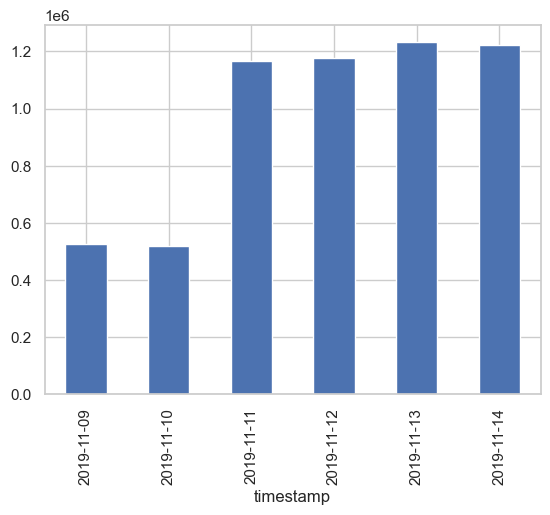

In [10]:
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])
interactions_df['timestamp'].describe()
interactions_df['timestamp'].dt.date.value_counts().sort_index().plot(kind='bar')
plt.show()


In [11]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5843444 entries, 0 to 5843443
Data columns (total 8 columns):
 #   Column         Dtype              
---  ------         -----              
 0   user_id        string             
 1   item_id        string             
 2   timestamp      datetime64[ns, UTC]
 3   impression_id  int64              
 4   position       int16              
 5   clicked        int8               
 6   history_len    int64              
 7   session_id     int64              
dtypes: datetime64[ns, UTC](1), int16(1), int64(3), int8(1), string(2)
memory usage: 328.8 MB


In [12]:
interactions_df.isnull().sum()

user_id          0
item_id          0
timestamp        0
impression_id    0
position         0
clicked          0
history_len      0
session_id       0
dtype: int64

In [13]:
interactions_df.head(30)

,user_id,item_id,timestamp,impression_id,position,clicked,history_len,session_id
0,U100,N61235,2019-11-12 07:34:12+00:00,107691,1,0,10,1
1,U100,N54489,2019-11-12 07:34:12+00:00,107691,2,0,10,1
2,U100,N42597,2019-11-12 07:34:12+00:00,107691,3,0,10,1
3,U100,N7800,2019-11-12 07:34:12+00:00,107691,4,1,10,1
4,U100,N61408,2019-11-12 07:34:12+00:00,107691,5,0,10,1
5,U100,N26415,2019-11-12 07:34:12+00:00,107691,6,0,10,1
6,U100,N20079,2019-11-12 07:34:12+00:00,107691,7,0,10,1
7,U100,N58271,2019-11-12 07:34:12+00:00,107691,8,0,10,1
8,U100,N6099,2019-11-12 07:34:12+00:00,107691,9,0,10,1
9,U100,N57554,2019-11-12 07:34:12+00:00,107691,10,0,10,1


In [14]:
interactions_df.tail(20)

,user_id,item_id,timestamp,impression_id,position,clicked,history_len,session_id
5843424,U9999,N57651,2019-11-10 16:59:19+00:00,122509,2,0,21,1
5843425,U9999,N23184,2019-11-10 16:59:19+00:00,122509,3,0,21,1
5843426,U9999,N37533,2019-11-10 16:59:19+00:00,122509,4,0,21,1
5843427,U9999,N15931,2019-11-10 16:59:19+00:00,122509,5,0,21,1
5843428,U9999,N26706,2019-11-10 16:59:19+00:00,122509,6,1,21,1
5843429,U9999,N18613,2019-11-10 16:59:19+00:00,122509,7,0,21,1
5843430,U9999,N26952,2019-11-10 16:59:19+00:00,122509,8,0,21,1
5843431,U9999,N23085,2019-11-10 16:59:19+00:00,122509,9,1,21,1
5843432,U9999,N50060,2019-11-10 16:59:19+00:00,122509,10,0,21,1
5843433,U9999,N55489,2019-11-10 16:59:19+00:00,122509,11,0,21,1


In [15]:
interaction_raw_df = pd.read_csv('../data/MINDsmall_dev/behaviors.tsv', sep='\t', header=None)
interaction_raw_df.head()

,0,1,2,3,4
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


In [16]:
interactions_df['user_id'].nunique()

50000

In [17]:
interactions_df['user_session_id'] = interactions_df['user_id'] + "-" + interactions_df['session_id'].astype(str)
interactions_df['user_session_id'].nunique()


146403

In [18]:
interactions_df.groupby('user_id')['session_id'].max().describe()

count    50000.000000
mean         2.928060
std          2.583993
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         55.000000
Name: session_id, dtype: float64

In [19]:
# 1개의 세션 안에서 동일한 item 이 여러번 impression 될수도 있음
interactions_df.groupby(['user_session_id'])['item_id'].nunique()- interactions_df.groupby(['user_session_id'])['item_id'].count()

user_session_id
U100-1      0
U1000-1     0
U1000-2     0
U1000-3     0
U10001-1    0
           ..
U9996-1     0
U9996-2    -5
U9997-1     0
U9997-2     0
U9999-1     0
Name: item_id, Length: 146403, dtype: int64

In [20]:
interactions_df['ad_hour'] = interactions_df['timestamp'].dt.hour
interactions_df['ad_hour'].value_counts().sort_index()

ad_hour
0      39084
1      46297
2      72567
3     124999
4     215813
5     341082
6     404391
7     415363
8     438956
9     375638
10    446885
11    445298
12    432752
13    409561
14    335504
15    238671
16    234701
17    202787
18    170465
19    136645
20    113403
21     88019
22     63749
23     50814
Name: count, dtype: int64

<Axes: xlabel='ad_hour', ylabel='count'>

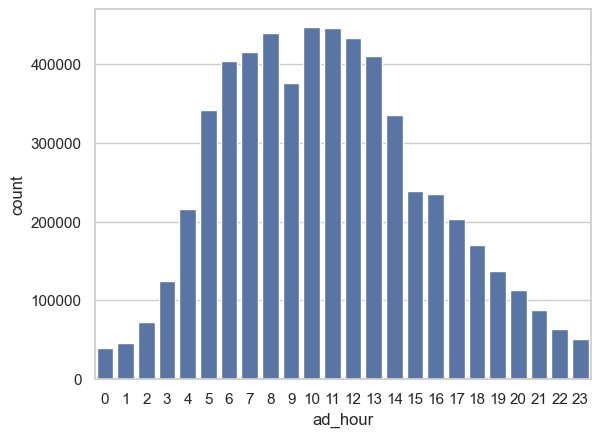

In [21]:
sns.barplot(data = interactions_df['ad_hour'].value_counts().sort_index().reset_index(), x='ad_hour',y='count')

<Axes: xlabel='ad_hour', ylabel='count'>

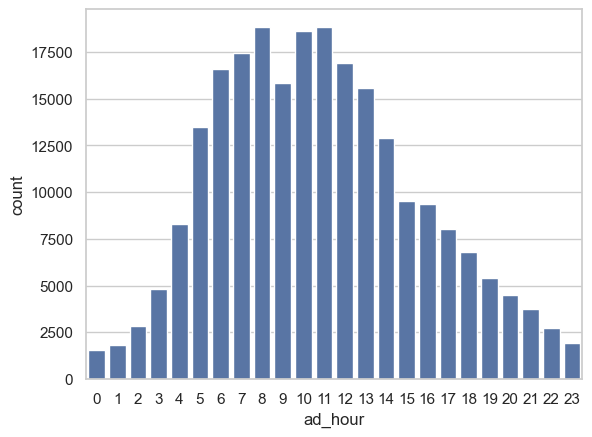

In [22]:
sns.barplot(data = interactions_df.loc[interactions_df['clicked']==1,'ad_hour'].value_counts().sort_index().reset_index(), x='ad_hour',y='count')

In [23]:
interactions_category = pd.merge(interactions_df[['user_id','item_id','timestamp','ad_hour','clicked']], items_df[['item_id','category','subcategory']], on='item_id',how='left')
interactions_category.head()

,user_id,item_id,timestamp,ad_hour,clicked,category,subcategory
0,U100,N61235,2019-11-12 07:34:12+00:00,7,0,lifestyle,causes
1,U100,N54489,2019-11-12 07:34:12+00:00,7,0,news,newsus
2,U100,N42597,2019-11-12 07:34:12+00:00,7,0,sports,baseball_mlb
3,U100,N7800,2019-11-12 07:34:12+00:00,7,1,news,newscrime
4,U100,N61408,2019-11-12 07:34:12+00:00,7,0,finance,markets


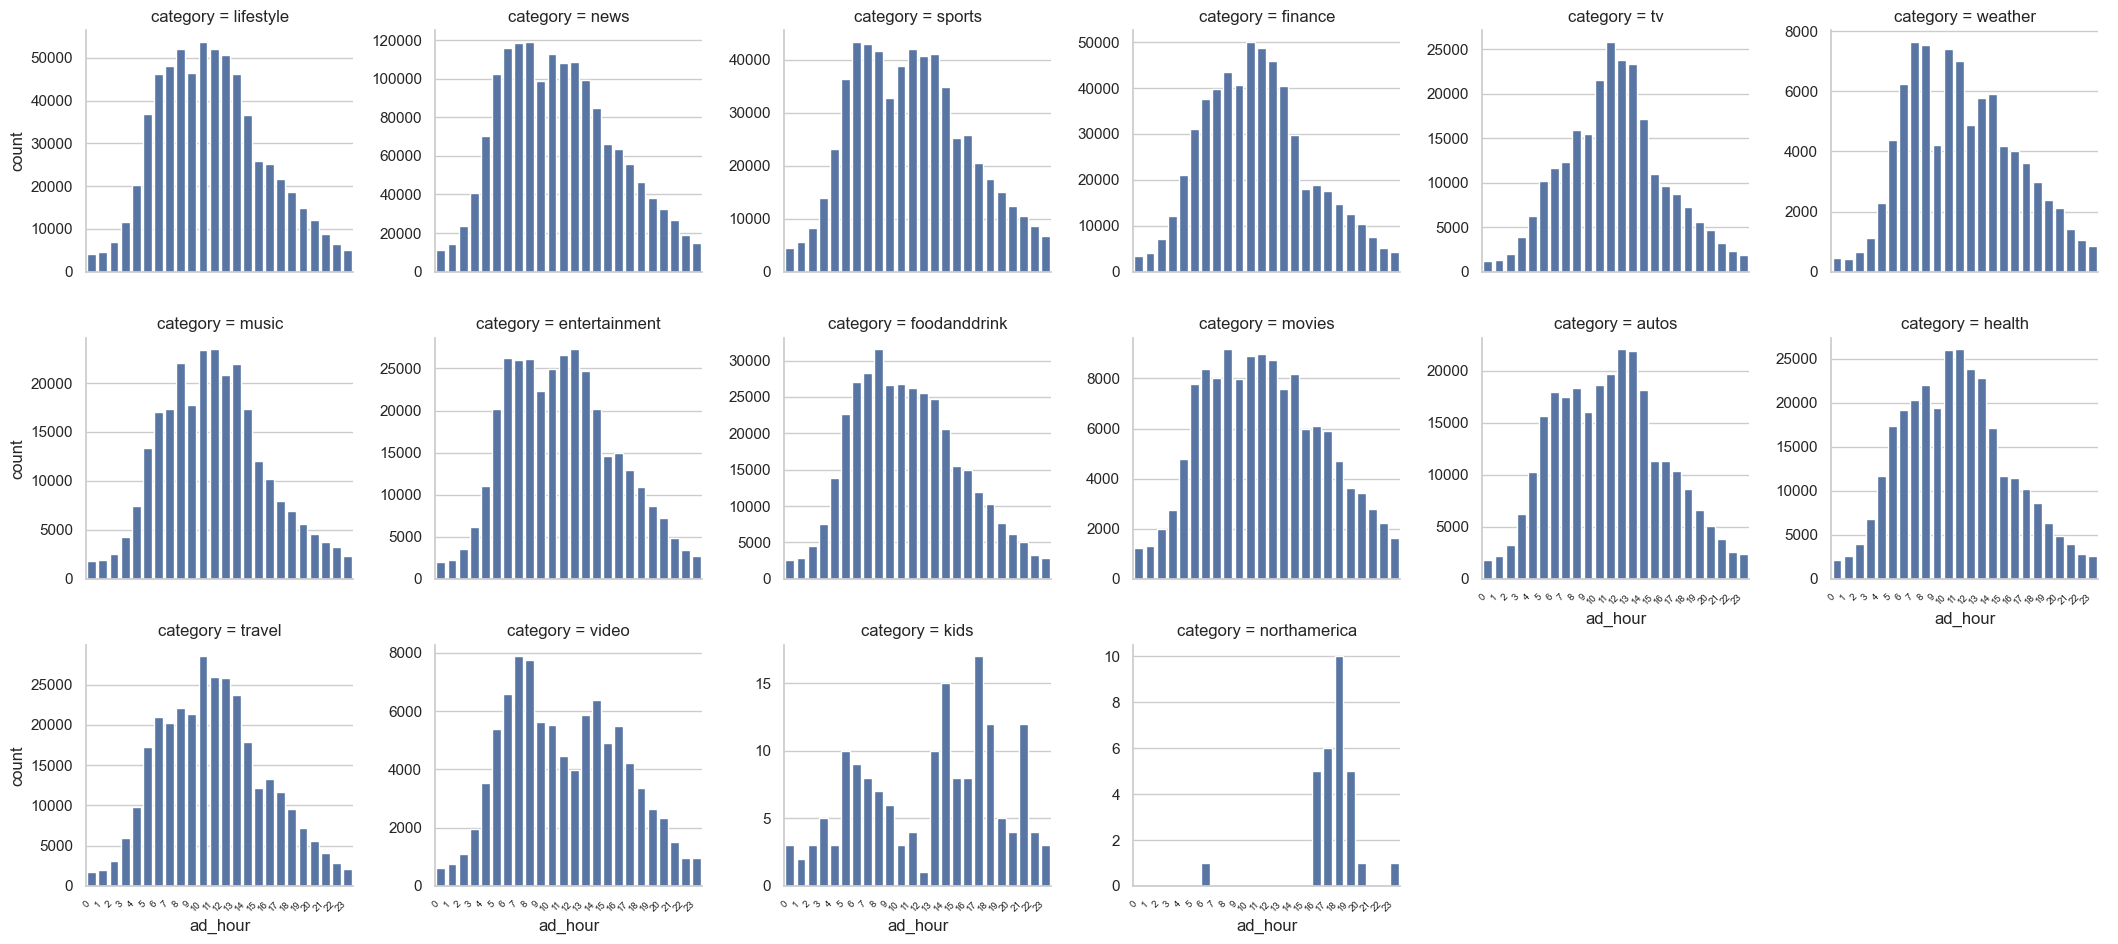

In [24]:
hours = list(range(24))
interactions_category["ad_hour"] = pd.Categorical(
    interactions_category["ad_hour"].astype(int),
    categories=hours, ordered=True
)

g = sns.catplot(
    data=interactions_category,
    kind="count",
    x="ad_hour",
    col="category",
    col_wrap=6,
    order=hours,         # 모든 facet에서 동일 순서 강제
    height=3.2,
    aspect=1.1,
    sharex=True,         # x축 공유(기본 True이지만 명시)
    sharey=False
)

# 모든 서브플롯에 동일한 눈금/라벨 강제
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(mticker.FixedLocator(range(len(hours))))
    ax.set_xticklabels(hours, rotation=45, ha="right", fontsize=7)

g.set_axis_labels("ad_hour", "count")
g.set_titles("category = {col_name}")
plt.tight_layout()
plt.show()

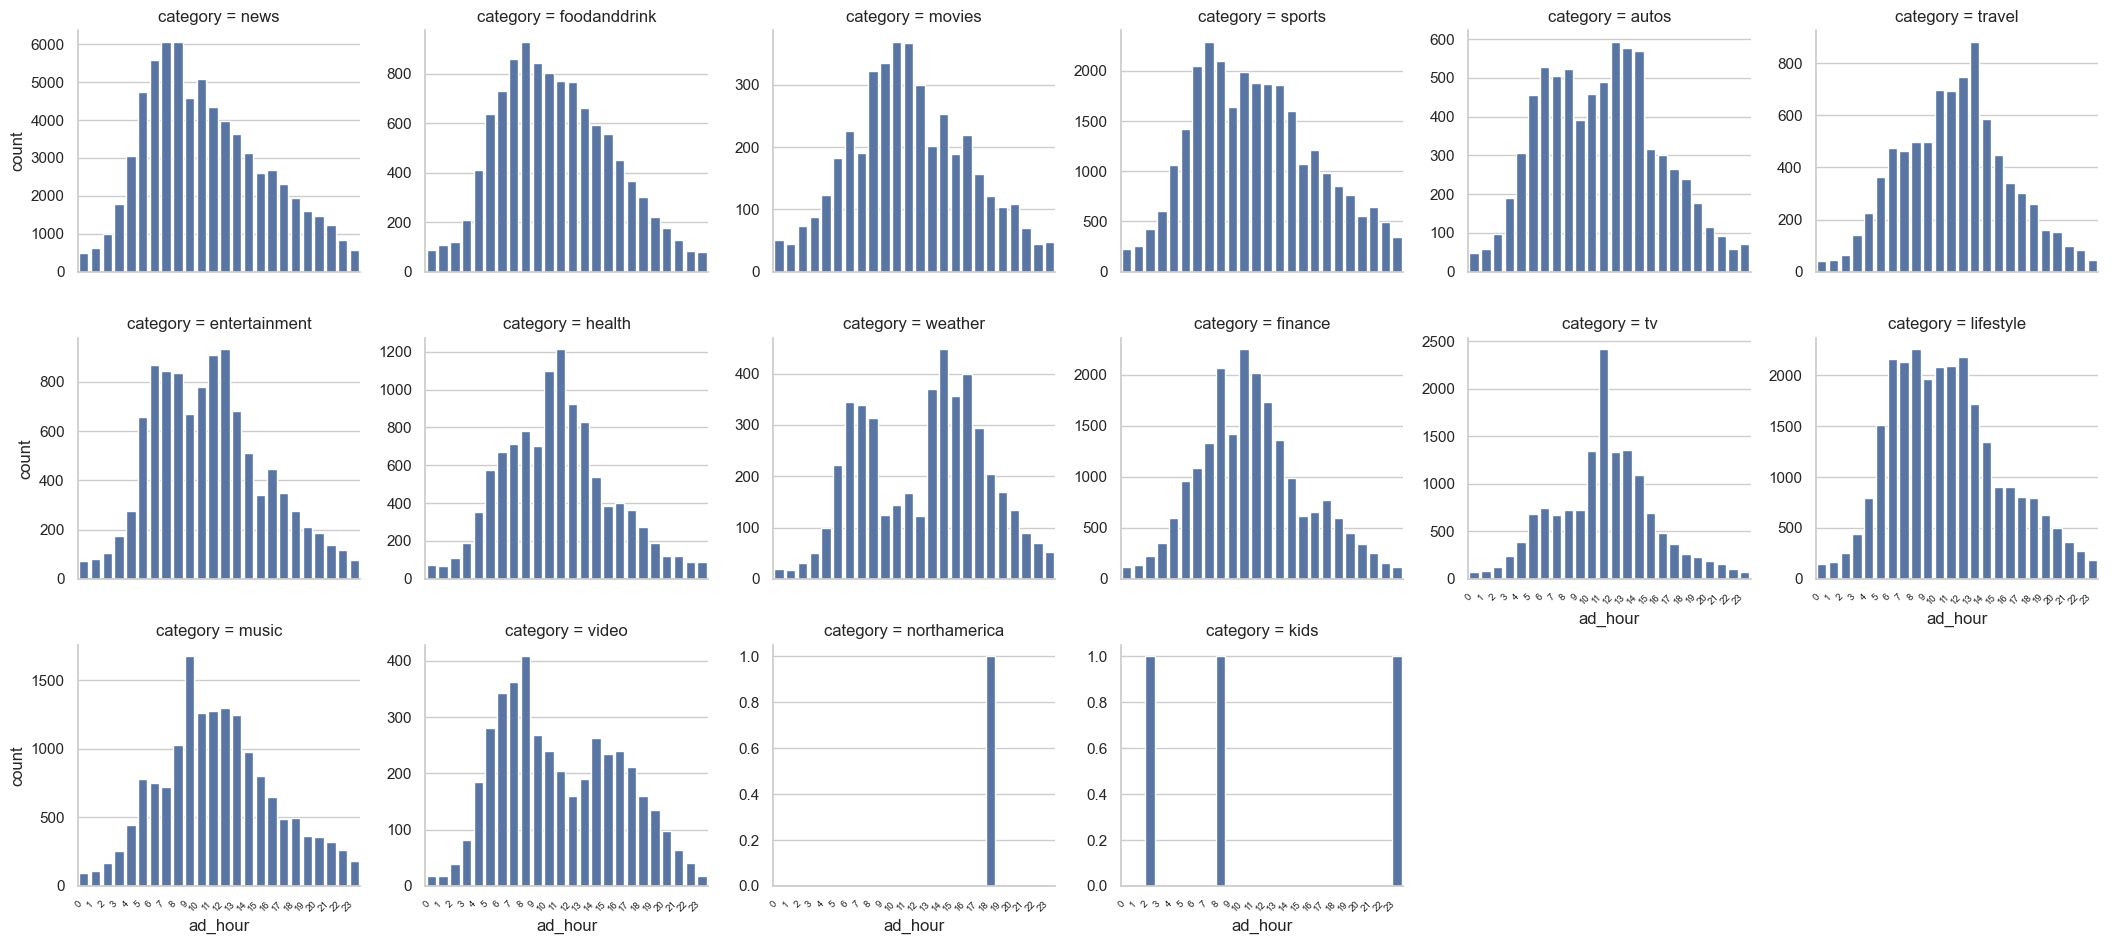

In [25]:
g = sns.catplot(
    data=interactions_category.loc[interactions_category['clicked']==1],
    kind="count",
    x="ad_hour",
    col="category",
    col_wrap=6,
    order=hours,         # 모든 facet에서 동일 순서 강제
    height=3.2,
    aspect=1.1,
    sharex=True,         # x축 공유(기본 True이지만 명시)
    sharey=False
)

# 모든 서브플롯에 동일한 눈금/라벨 강제
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(mticker.FixedLocator(range(len(hours))))
    ax.set_xticklabels(hours, rotation=45, ha="right", fontsize=7)

g.set_axis_labels("ad_hour", "count")
g.set_titles("category = {col_name}")
plt.tight_layout()
plt.show()

In [26]:
#ctr
# user level 
# user session level => user 세션 내 clicked items / unique items
# category level => category 별 clikecd items / total category items
# user session ctr 의 시간대별 분포 

In [27]:
interactions_df.head()

,user_id,item_id,timestamp,impression_id,position,clicked,history_len,session_id,user_session_id,ad_hour
0,U100,N61235,2019-11-12 07:34:12+00:00,107691,1,0,10,1,U100-1,7
1,U100,N54489,2019-11-12 07:34:12+00:00,107691,2,0,10,1,U100-1,7
2,U100,N42597,2019-11-12 07:34:12+00:00,107691,3,0,10,1,U100-1,7
3,U100,N7800,2019-11-12 07:34:12+00:00,107691,4,1,10,1,U100-1,7
4,U100,N61408,2019-11-12 07:34:12+00:00,107691,5,0,10,1,U100-1,7


In [28]:
user_imp_items = interactions_df.groupby(['user_id'])['item_id'].count()
user_click_items = interactions_df.loc[interactions_df['clicked']==1].groupby(['user_id'])['item_id'].count()

user_ctr = user_click_items/user_imp_items
user_ctr

user_id
U100      0.009524
U1000     0.019512
U10001    0.035714
U10003    0.028302
U10008    0.013889
            ...   
U9993     0.036364
U9995     0.046610
U9996     0.157895
U9997     0.052632
U9999     0.142857
Name: item_id, Length: 50000, dtype: float64

In [29]:
user_ctr.describe()

count    50000.000000
mean         0.085461
std          0.104511
min          0.003448
25%          0.028986
50%          0.048544
75%          0.090909
max          0.666667
Name: item_id, dtype: float64

In [30]:
session_imp_items = interactions_df.groupby(['user_session_id'])['item_id'].count()
session_click_items = interactions_df.loc[interactions_df['clicked']==1].groupby(['user_session_id'])['item_id'].count()

session_ctr = session_click_items/session_imp_items
session_ctr

user_session_id
U100-1      0.009524
U1000-1     0.017857
U1000-2     0.021739
U1000-3     0.017544
U10001-1    0.125000
              ...   
U9996-1     0.250000
U9996-2     0.133333
U9997-1     0.053571
U9997-2     0.047619
U9999-1     0.142857
Name: item_id, Length: 146403, dtype: float64

In [31]:
session_ctr.describe()

count    146403.000000
mean          0.106402
std           0.128015
min           0.003367
25%           0.028571
50%           0.055556
75%           0.125000
max           0.750000
Name: item_id, dtype: float64

In [32]:
session_ctr_df = session_ctr.reset_index()
session_ctr_df.columns = ['user_session_id','ctr']
session_ctr_df = pd.merge(session_ctr_df, interactions_df[['user_session_id','timestamp','ad_hour']].drop_duplicates(),on='user_session_id',how='left')
session_ctr_df

,user_session_id,ctr,timestamp,ad_hour
0,U100-1,0.009524,2019-11-12 07:34:12+00:00,7
1,U1000-1,0.017857,2019-11-13 23:16:18+00:00,23
2,U1000-2,0.021739,2019-11-14 01:00:56+00:00,1
3,U1000-3,0.017544,2019-11-14 22:37:21+00:00,22
4,U10001-1,0.125000,2019-11-11 05:30:21+00:00,5
...,...,...,...,...
156943,U9996-2,0.133333,2019-11-14 08:40:37+00:00,8
156944,U9996-2,0.133333,2019-11-14 08:41:12+00:00,8
156945,U9997-1,0.053571,2019-11-13 10:06:28+00:00,10
156946,U9997-2,0.047619,2019-11-13 14:41:42+00:00,14


<Axes: xlabel='ad_hour', ylabel='ctr'>

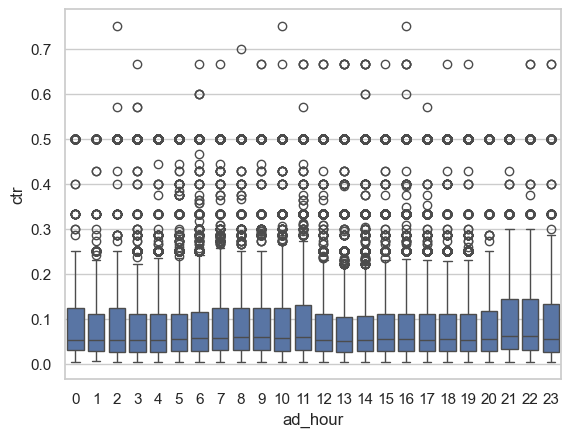

In [33]:
sns.boxplot(data = session_ctr_df, x='ad_hour',y='ctr')

In [34]:
session_ctr_df.groupby('ad_hour')['ctr'].describe()

,count,mean,std,min,25%,50%,75%,max
ad_hour,,,,,,,,
0,1017.0,0.109430,0.133578,0.003802,0.030075,0.052632,0.125000,0.500000
1,1152.0,0.099561,0.122848,0.005102,0.027778,0.052632,0.111111,0.500000
2,1816.0,0.109189,0.138029,0.004016,0.027027,0.052290,0.125000,0.750000
3,3064.0,0.104051,0.129472,0.003401,0.027027,0.052632,0.111111,0.666667
4,5319.0,0.100048,0.124992,0.003802,0.026316,0.052632,0.111111,0.500000
5,8587.0,0.102960,0.125901,0.003390,0.027778,0.054054,0.111111,0.500000
6,10749.0,0.106146,0.128576,0.003623,0.029412,0.057143,0.115385,0.666667
7,11550.0,0.109893,0.132115,0.003448,0.030612,0.056604,0.125000,0.666667
8,12494.0,0.110150,0.129280,0.003484,0.031250,0.058824,0.125000,0.700000


In [35]:
category_imp_items = interactions_category.groupby(['category'])['item_id'].count()
category_click_items = interactions_category.loc[interactions_category['clicked']==1].groupby(['category'])['item_id'].count()

category_ctr = category_click_items/category_imp_items
category_ctr.sort_values()

category
kids             0.018519
travel           0.026353
autos            0.027367
foodanddrink     0.029463
entertainment    0.030092
movies           0.031690
northamerica     0.034483
health           0.035723
finance          0.036476
lifestyle        0.040559
news             0.043624
video            0.045464
sports           0.047585
weather          0.051689
tv               0.059011
music            0.059433
Name: item_id, dtype: float64

In [36]:
interactions_df['position'].value_counts().head(10)

position
1     156965
2     156965
3     146456
4     142952
5     136143
6     133254
7     130201
8     123836
9     121522
10    118644
Name: count, dtype: int64

In [37]:
position_imp_items = interactions_df.groupby(['position'])['item_id'].count()
position_click_items = interactions_df.loc[interactions_df['clicked']==1].groupby(['position'])['item_id'].count()

position_ctr = position_click_items/position_imp_items
position_ctr.describe()

count    276.000000
mean       0.021429
std        0.013549
min        0.001992
25%        0.014395
50%        0.018914
75%        0.023144
max        0.108247
Name: item_id, dtype: float64

<Axes: xlabel='ad_hour'>

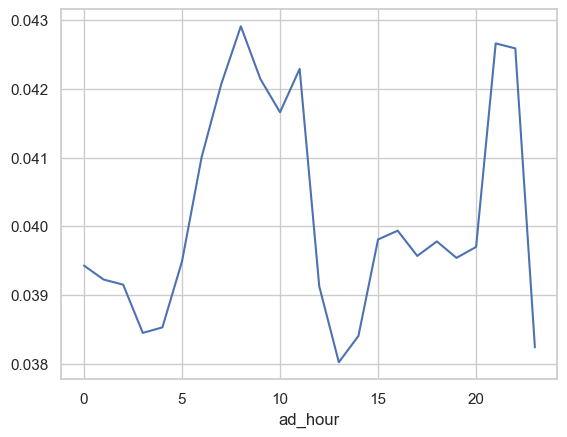

In [38]:
time_imp_items = interactions_df.groupby(['ad_hour'])['item_id'].count()
time_click_items = interactions_df.loc[interactions_df['clicked']==1].groupby(['ad_hour'])['item_id'].count()

time_ctr = time_click_items/time_imp_items
time_ctr.plot(kind='line')

In [39]:
interactions_category

,user_id,item_id,timestamp,ad_hour,clicked,category,subcategory
0,U100,N61235,2019-11-12 07:34:12+00:00,7,0,lifestyle,causes
1,U100,N54489,2019-11-12 07:34:12+00:00,7,0,news,newsus
2,U100,N42597,2019-11-12 07:34:12+00:00,7,0,sports,baseball_mlb
3,U100,N7800,2019-11-12 07:34:12+00:00,7,1,news,newscrime
4,U100,N61408,2019-11-12 07:34:12+00:00,7,0,finance,markets
...,...,...,...,...,...,...,...
5843439,U9999,N41224,2019-11-10 16:59:19+00:00,16,0,news,newspolitics
5843440,U9999,N27349,2019-11-10 16:59:19+00:00,16,0,autos,autosclassics
5843441,U9999,N61022,2019-11-10 16:59:19+00:00,16,1,news,newscrime
5843442,U9999,N11830,2019-11-10 16:59:19+00:00,16,0,lifestyle,lifestylepetsanimals


In [40]:
# 유저 별로 본 기사의 카테고리 가짓수
user_category_view = interactions_category.groupby(['user_id'])['category'].nunique()
user_category_view.describe()

count    50000.000000
mean        10.841980
std          3.570163
min          1.000000
25%          9.000000
50%         12.000000
75%         14.000000
max         15.000000
Name: category, dtype: float64

In [41]:
# train & holdout set 구성
interactions_df.head()

,user_id,item_id,timestamp,impression_id,position,clicked,history_len,session_id,user_session_id,ad_hour
0,U100,N61235,2019-11-12 07:34:12+00:00,107691,1,0,10,1,U100-1,7
1,U100,N54489,2019-11-12 07:34:12+00:00,107691,2,0,10,1,U100-1,7
2,U100,N42597,2019-11-12 07:34:12+00:00,107691,3,0,10,1,U100-1,7
3,U100,N7800,2019-11-12 07:34:12+00:00,107691,4,1,10,1,U100-1,7
4,U100,N61408,2019-11-12 07:34:12+00:00,107691,5,0,10,1,U100-1,7


In [42]:
# session 이 1개인 유저가 있음 (35%정도의 유저가 1개의 session 만 가짐)
user_session_cnt = interactions_df.groupby(['user_id'])['user_session_id'].nunique()
print(user_session_cnt.describe())
print(user_session_cnt[user_session_cnt>1].shape[0] / user_session_cnt.shape[0])

count    50000.000000
mean         2.928060
std          2.583993
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         55.000000
Name: user_session_id, dtype: float64
0.65886


In [44]:
user_impression_group_cnt = interactions_df.groupby(['user_id'])['impression_id'].nunique()
print(user_impression_group_cnt.describe())
print(user_impression_group_cnt[user_impression_group_cnt>1].shape[0] / user_impression_group_cnt.shape[0])

count    50000.000000
mean         3.139300
std          3.001026
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         62.000000
Name: impression_id, dtype: float64
0.67234


In [45]:

def split_user_last_impression(df: pd.DataFrame) -> pd.DataFrame:
    """
    입력 df 컬럼 가정:
      user_id, impression_id, timestamp(UTC), ...
    출력:
      df에 split(train/valid/test/ignore) 컬럼 추가
    정책:
      - 인상 1개 유저: ignore(제외)
      - 인상 2개 유저: 마지막=test, 나머지=train
      - 인상 ≥3개 유저: 마지막=test, 마지막-1=valid, 나머지=train
    """
    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"], utc=True)

    # 인상 대표 시각(한 인상에 여러 row가 있으므로 인상단위 최소 시각 사용)
    imp_ts = (d.groupby("impression_id")["timestamp"].min()
                .rename("imp_ts").reset_index())

    # 유저-인상 수준의 테이블
    ui = (d[["user_id","impression_id"]]
          .drop_duplicates()
          .merge(imp_ts, on="impression_id", how="left")
          .sort_values(["user_id","imp_ts"], kind="mergesort"))

    # 유저별 인상 수 & 순위
    cnt = ui.groupby("user_id")["impression_id"].transform("count").rename("imp_cnt")
    ui["imp_cnt"] = cnt
    ui["imp_rank"] = ui.groupby("user_id").cumcount() + 1  # 1..n (시간 오름차순)

    # 분할 규칙
    ui["split_imp"] = "train"
    # 1개 유저 → ignore
    ui.loc[ui["imp_cnt"] == 1, "split_imp"] = "ignore"
    # 마지막 인상 → test
    ui.loc[ui["imp_rank"] == ui["imp_cnt"], "split_imp"] = "test"
    # 마지막-1 → valid (imp_cnt >= 3에서만)
    mask_valid = (ui["imp_cnt"] >= 3) & (ui["imp_rank"] == ui["imp_cnt"] - 1)
    ui.loc[mask_valid, "split_imp"] = "valid"

    # 행 단위로 확장 병합 (동일 인상은 모두 동일 split)
    d = d.merge(ui[["impression_id","split_imp"]], on="impression_id", how="left")
    d = d.rename(columns={"split_imp":"split"})
    return d

# 사용 예시
# interactions: 전처리된 MIND 인터랙션 테이블
splitted_df = split_user_last_impression(interactions_df)

# 확인
print(splitted_df["split"].value_counts(dropna=False))


split
train    3152638
test     1871178
valid     819628
Name: count, dtype: int64
